<a href="https://colab.research.google.com/github/martinfernandoortiz/geoestadistica_unlp/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Rodrigo Morel - Martín Fernando Ortiz
#Geoestadística - Maestría de Geomática -- UNLP
## Análisis de datos meteorológicos
### Objetivo General
Realizar una reducción de las dimensiones del dataset principal para la delimitación de zonas meteorológicas

### Objetivos Específicos
- Hacer un análisis descriptivo de la información del dataset
- Tratar los datos outliers
- Generar una interpolación para el caso en que tengamos No Datos
- Realizar un análisis PCA
- Utilizar alguna técnica de Cluster para generar regiones climatológicas

### Software utilizado
Jupyter / Colab - Python

### Dataset utilizado
Dataset de la cátedra de Geoestadística


In [98]:
# @title
# Carga de librerías
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from joblib import dump, load

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
df = pd.read_csv('/content/drive/My Drive/datasets_colab/final/smn_coord.csv')
df_sincorregir = pd.read_excel('/content/drive/My Drive/datasets_colab/final/SMN_estaciones_medias_mensuales_1989_2010.xls')
country_boundaries = gpd.read_file('/content/drive/My Drive/datasets_colab/final/pais.gpkg')

#archivo = "SMN_estaciones_medias_mensuales_1989_2010.xls"
#df = pd.read_excel(archivo)

Antes de trabajar con el dataset se le hizo una limpieza a los datos de coordenadas que éste poseia dado que la localización de las estaciones no era correcta. La limpieza se realizó desde QGIS.

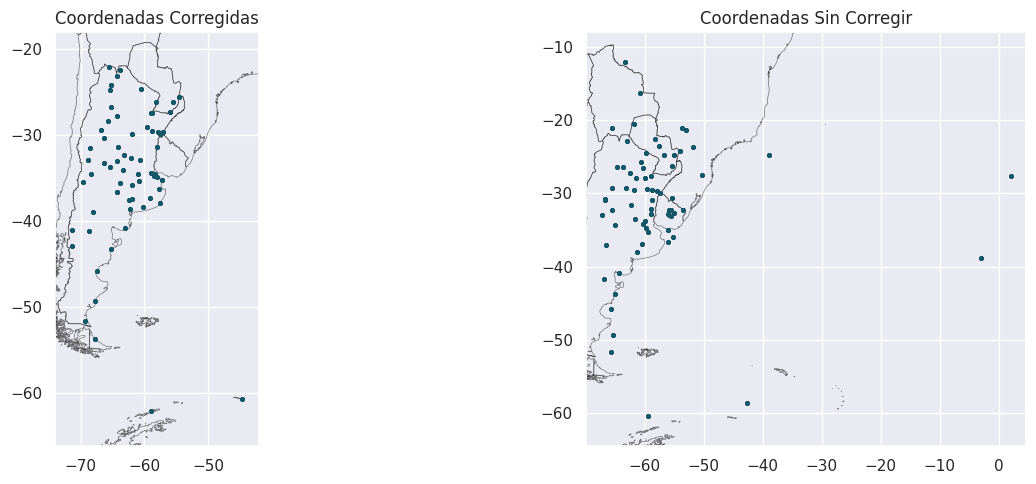

In [100]:

# Supongamos que tienes dos GeoDataFrames llamados gdf y gdf1


gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['long'], df['lat']), crs='EPSG:4326')
gdf1 = gpd.GeoDataFrame(df_sincorregir, geometry=gpd.points_from_xy(df_sincorregir['long'], df_sincorregir['lat']), crs='EPSG:4326')

# Crear el mapa con dos subgráficos (1 fila, 2 columnas)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# ---- Plotear el primer DataFrame (gdf) ----
ax = axs[0]  # Seleccionar el primer subgráfico

# Plotear la capa de polígonos (límites del país)
pais.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=0.5, facecolor='none')

# Plotear la capa de puntos con colores basados en alguna columna
gdf.plot(ax=ax, color='#145769', marker='o', markersize=5)

# Ajustar los límites del gráfico
x_min, y_min, x_max, y_max = gdf.total_bounds
margin_scale = 0.1
x_range = x_max - x_min
y_range = y_max - y_min
x_min_adjusted = x_min - margin_scale * x_range
x_max_adjusted = x_max + margin_scale * x_range
y_min_adjusted = y_min - margin_scale * y_range
y_max_adjusted = y_max + margin_scale * y_range
ax.set_xlim(x_min_adjusted, x_max_adjusted)
ax.set_ylim(y_min_adjusted, y_max_adjusted)

# Añadir título al subgráfico
ax.set_title("Coordenadas Corregidas")

# ---- Plotear el segundo DataFrame (gdf1) ----
ax = axs[1]  # Seleccionar el segundo subgráfico

# Plotear la capa de polígonos (límites del país)
pais.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=0.5, facecolor='none')

# Plotear la capa de puntos con colores basados en alguna columna
gdf1.plot(ax=ax, color='#145769', marker='o', markersize=5)

# Ajustar los límites del gráfico
x_min, y_min, x_max, y_max = gdf1.total_bounds
x_min_adjusted = x_min - margin_scale * x_range
x_max_adjusted = x_max + margin_scale * x_range
y_min_adjusted = y_min - margin_scale * y_range
y_max_adjusted = y_max + margin_scale * y_range
ax.set_xlim(x_min_adjusted, x_max_adjusted)
ax.set_ylim(y_min_adjusted, y_max_adjusted)

# Añadir título al subgráfico
ax.set_title("Coordenadas Sin Corregir")

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()

# Mostrar el mapa
plt.show()

Estructura General del Dataset
Con los métodos XXX , podemos ver la estructura general del dataset (largo,nombre y tipo de columnas) cantidad de Nodatos, tipos de Datos, etc.

El dataset contiene información meteorológica de las estaciones XXX para cada mes

boxplot de todos......

In [101]:
print(df.dtypes) #tipo de dato por columna
print(df_sincorregir.dtypes) #tipo de dato por columna

fid                                        int64
...1                                       int64
Estacion                                  object
mes                                       object
lat                                      float64
long                                     float64
Altura_(m)                                 int64
Numero                                     int64
Temperatura_(C)                          float64
Temperatura_maxima_(C)                   float64
Temperatura_minima_(C)                   float64
Humedad_relativa_(%)                     float64
Velocidad_del_Viento_(km/h)              float64
Nubosidad_total_(octavos)                float64
Precipitacion_(mm)                       float64
Frecuencia_dias_Precipitacion_>0.1_mm    float64
dtype: object
Unnamed: 0.1                               int64
Unnamed: 0                                 int64
Estacion                                  object
mes                                       object
lat   

In [102]:
#transformamos a númerico
df[["Temperatura_(C)","Temperatura_minima_(C)", "Humedad_relativa_(%)","Velocidad_del_Viento_(km/h)", "Nubosidad_total_(octavos)","Precipitacion_(mm)",
    "Frecuencia_dias_Precipitacion_>0.1_mm"]] = df[["Temperatura_(C)","Temperatura_minima_(C)", "Humedad_relativa_(%)","Velocidad_del_Viento_(km/h)",
                                                    "Nubosidad_total_(octavos)","Precipitacion_(mm)","Frecuencia_dias_Precipitacion_>0.1_mm"]].astype(float)

df_sincorregir.replace("S/D", np.NaN, inplace = True) #reemplazar los "S/D"
df_sincorregir[["Temperatura_(C)","Temperatura_minima_(C)", "Humedad_relativa_(%)","Velocidad_del_Viento_(km/h)", "Nubosidad_total_(octavos)","Precipitacion_(mm)",
    "Frecuencia_dias_Precipitacion_>0.1_mm"]] = df_sincorregir[["Temperatura_(C)","Temperatura_minima_(C)", "Humedad_relativa_(%)","Velocidad_del_Viento_(km/h)",
                                                    "Nubosidad_total_(octavos)","Precipitacion_(mm)","Frecuencia_dias_Precipitacion_>0.1_mm"]].astype(float)

In [103]:
# @title
df.dtypes #tipo de dato por columna

fid                                        int64
...1                                       int64
Estacion                                  object
mes                                       object
lat                                      float64
long                                     float64
Altura_(m)                                 int64
Numero                                     int64
Temperatura_(C)                          float64
Temperatura_maxima_(C)                   float64
Temperatura_minima_(C)                   float64
Humedad_relativa_(%)                     float64
Velocidad_del_Viento_(km/h)              float64
Nubosidad_total_(octavos)                float64
Precipitacion_(mm)                       float64
Frecuencia_dias_Precipitacion_>0.1_mm    float64
dtype: object

Estadística descriptiva del Dataset

In [104]:
df_sincorregir.iloc[:, np.r_[8:16]].describe()

,Temperatura_(C),Temperatura_maxima_(C),Temperatura_minima_(C),Humedad_relativa_(%),Velocidad_del_Viento_(km/h),Nubosidad_total_(octavos),Precipitacion_(mm),Frecuencia_dias_Precipitacion_>0.1_mm
count,838.000000,840.000000,818.000000,812.000000,708.000000,826.000000,807.000000,807.000000
mean,15.871838,22.411667,10.225428,68.044581,12.456497,3.817191,69.334944,6.756877
std,6.996565,7.443672,6.775667,10.828241,5.390830,0.764862,52.093688,2.763202
min,-11.600000,-7.300000,-16.800000,30.100000,3.000000,1.400000,0.000000,0.000000
25%,11.200000,18.000000,5.525000,62.175000,8.700000,3.400000,23.400000,4.750000
50%,16.300000,23.100000,10.700000,70.200000,11.300000,3.700000,59.000000,7.100000
75%,21.700000,28.300000,15.475000,76.325000,14.800000,4.100000,108.600000,8.700000
max,27.900000,35.100000,22.300000,88.100000,30.800000,7.500000,237.000000,16.300000


In [105]:
df_sincorregir.head()

,Unnamed: 0.1,Unnamed: 0,Estacion,mes,lat,long,Altura_(m),Numero,Temperatura_(C),Temperatura_maxima_(C),Temperatura_minima_(C),Humedad_relativa_(%),Velocidad_del_Viento_(km/h),Nubosidad_total_(octavos),Precipitacion_(mm),Frecuencia_dias_Precipitacion_>0.1_mm
0,0,0,LA QUIACA,ene,-12.0,-63.333333,3459,87007,12.8,20.1,7.4,65.3,6.9,5.2,97.5,15.9
1,1,1,LA QUIACA,feb,-12.0,-63.333333,3459,87007,12.5,19.9,7.0,64.1,7.1,4.8,68.4,12.2
2,2,2,LA QUIACA,mar,-12.0,-63.333333,3459,87007,12.4,19.9,6.3,62.4,6.5,4.1,55.9,9.8
3,3,3,LA QUIACA,abril,-12.0,-63.333333,3459,87007,10.9,19.7,2.8,48.2,6.4,2.7,8.2,2.4
4,4,4,LA QUIACA,mayo,-12.0,-63.333333,3459,87007,6.9,17.3,-3.0,34.6,6.0,1.8,1.0,0.3


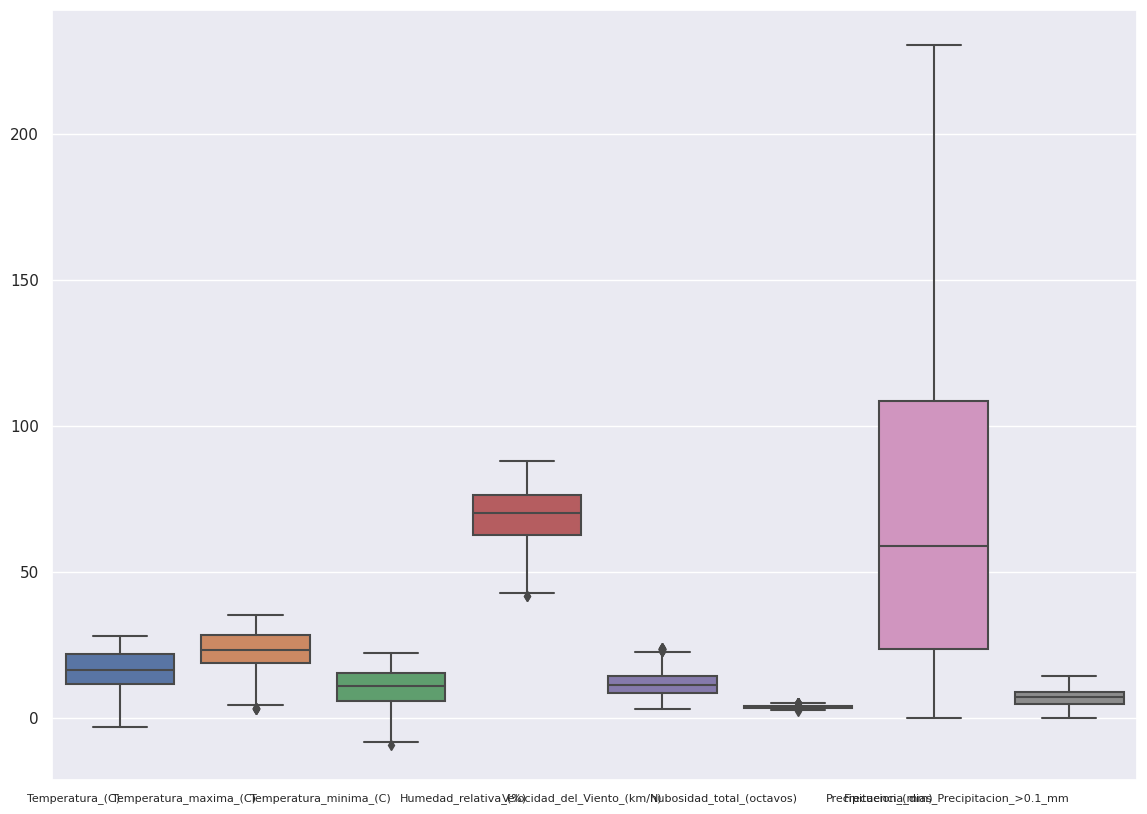

In [106]:
import seaborn as sns

# Crear el boxplot con Seaborn
all_data = df.iloc[:, np.r_[8:16]]
labels = all_data.columns.tolist()

sns.set(rc={"figure.figsize": (14, 10)})

# Crear el boxplot
ax = sns.boxplot(data=all_data)

# Ajustar las etiquetas del eje x
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right', fontsize=8)

# Mostrar el gráfico
plt.show()

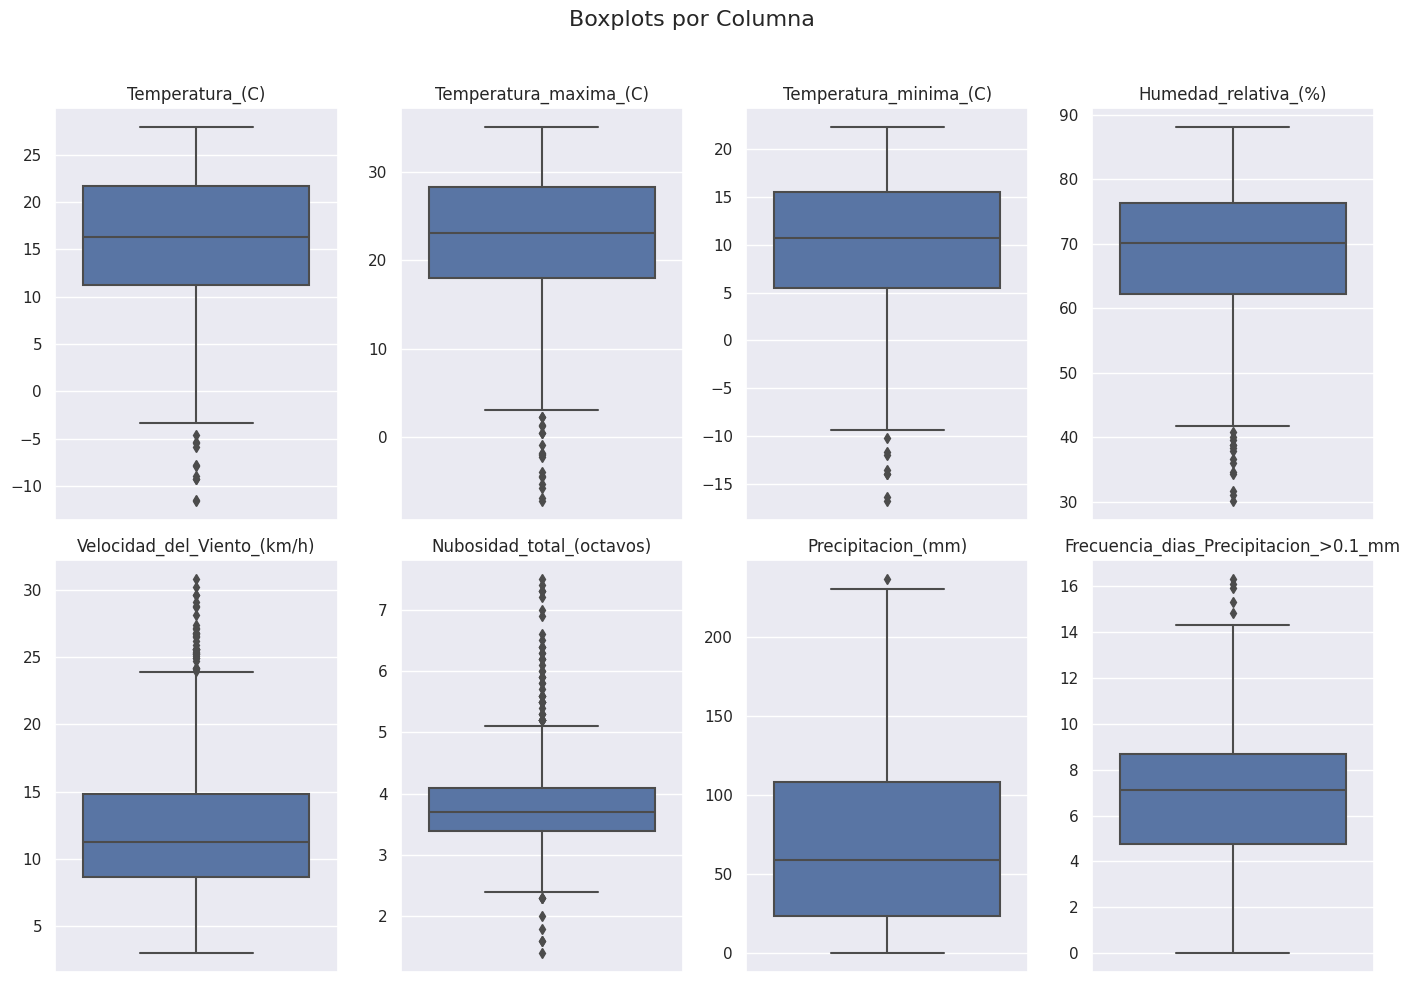

In [107]:
df_boxplot = df_sincorregir.iloc[:, np.r_[8:16]]
columns_for_boxplot = df_boxplot.columns

# Crear subgráficos para cada columna
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(14, 10))
fig.suptitle("Boxplots por Columna", fontsize=16)

# Iterar sobre las columnas y crear los boxplots
for i, col in enumerate(columns_for_boxplot):
    row = i // 4
    col_position = i % 4  # Cambiado el nombre de la variable
    sns.boxplot(y=df_boxplot[col], ax=axs[row, col_position], orient='v', whis=1.5)  # Especifica la orientación vertical
    axs[row, col_position].set_title(col)
    axs[row, col_position].set(xlabel=None, ylabel=None)  # Eliminar etiquetas de los ejes

# Ajustar el diseño y mostrar los gráficos
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


A partír de ésto surge el interrogante de cómo manejar los outliers. ¿Los cambiamos por la media? Los cambiamos por la media de la estación?

Es interesante plantear si esos outliers son errores en las mediciones o tienen que ver con las condiciones geográficas que puede haber en el lugar. Ejemplo de ésto las temperaturas mínimas en las bases antarticas

Vamos a visualizar el porcentaje de datos por fuera de los bigotes del boxplot, cuanto este esta definido como Q1 − 1.5 ∗ RI y Q3 + 1.5 ∗ RI.


In [108]:
# @title
def f(row):
    if row[colname] < lower_lim:
        val = 'Es Outlier'
    elif row[colname] > upper_lim:
        val = 'Es Outlier'
    else:
        val = 'No es Outlier'
    return val

In [109]:
outliers_df = pd.DataFrame()
#type(estadisticos)
rango= np.r_[8:16]
y= 0

for x in rango:

    colname = df_sincorregir.columns[x]
   # print(colname)
    Q1 = df_sincorregir[colname].quantile(0.25)
    Q3 = df_sincorregir[colname].quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR
    df_sincorregir['outlier'] = df.apply(f, axis=1)


    porcentaje =df_sincorregir['outlier'].value_counts(normalize=True).rename(colname)

    lower_lim_ = pd.Series({"lower_lim":lower_lim}).rename(colname)
    upper_lim_ = pd.Series({"upper_lim":upper_lim}).rename(colname)

    porcentaje= pd.concat([porcentaje, lower_lim_], axis=0)
    porcentaje= pd.concat([porcentaje, upper_lim_], axis=0)
   # porcentaje = porcentaje.append(lower_lim_).rename(colname)
   # porcentaje = porcentaje.append(upper_lim_).rename(colname)

   # print(porcentaje)
    outliers_df = pd.concat ([outliers_df,porcentaje], axis=1)
    #outliers_df = outliers_df.append(porcentaje,ignore_index=False)
    #print(outliers_df)

outliers_df

,Temperatura_(C),Temperatura_maxima_(C),Temperatura_minima_(C),Humedad_relativa_(%),Velocidad_del_Viento_(km/h),Nubosidad_total_(octavos),Precipitacion_(mm),Frecuencia_dias_Precipitacion_>0.1_mm
No es Outlier,1.00,1.00,1.0,1.00,1.00,1.00,1.0,1.000
lower_lim,-4.55,2.55,-9.4,40.95,-0.45,2.35,-104.4,-1.175
upper_lim,37.45,43.75,30.4,97.55,23.95,5.15,236.4,14.625


from matplotlib import pyplot as plt
outliers_df['Temperatura_(C)'].plot(kind='hist', bins=20, title='Temperatura_(C)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
outliers_df['Temperatura_maxima_(C)'].plot(kind='hist', bins=20, title='Temperatura_maxima_(C)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
outliers_df['Temperatura_minima_(C)'].plot(kind='hist', bins=20, title='Temperatura_minima_(C)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
outliers_df['Humedad_relativa_(%)'].plot(kind='hist', bins=20, title='Humedad_relativa_(%)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
outliers_df.plot(kind='scatter', x='Temperatura_(C)', y='Temperatura_maxima_(C)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
outliers_df.plot(kind='scatter', x='Temperatura_maxima_(C)', y='Temperatura_minima_(C)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
outliers_df.plot(kind='scatter', x='Temperatura_minima_(C)', y='Humedad_relativa_(%)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
outliers_df.plot(kind='scatter', x='Humedad_relativa_(%)', y='Velocidad_del_Viento_(km/h)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Temperatura_maxima_(C)']
  ys = series['Temperatura_(C)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = outliers_df.sort_values('Temperatura_maxima_(C)', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Temperatura_maxima_(C)')
_ = plt.ylabel('Temperatura_(C)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Temperatura_maxima_(C)']
  ys = series['Temperatura_minima_(C)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = outliers_df.sort_values('Temperatura_maxima_(C)', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Temperatura_maxima_(C)')
_ = plt.ylabel('Temperatura_minima_(C)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Temperatura_maxima_(C)']
  ys = series['Velocidad_del_Viento_(km/h)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = outliers_df.sort_values('Temperatura_maxima_(C)', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Temperatura_maxima_(C)')
_ = plt.ylabel('Velocidad_del_Viento_(km/h)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Temperatura_maxima_(C)']
  ys = series['Precipitacion_(mm)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = outliers_df.sort_values('Temperatura_maxima_(C)', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Temperatura_maxima_(C)')
_ = plt.ylabel('Precipitacion_(mm)')

from matplotlib import pyplot as plt
outliers_df['Temperatura_(C)'].plot(kind='line', figsize=(8, 4), title='Temperatura_(C)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
outliers_df['Temperatura_maxima_(C)'].plot(kind='line', figsize=(8, 4), title='Temperatura_maxima_(C)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
outliers_df['Temperatura_minima_(C)'].plot(kind='line', figsize=(8, 4), title='Temperatura_minima_(C)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
outliers_df['Humedad_relativa_(%)'].plot(kind='line', figsize=(8, 4), title='Humedad_relativa_(%)')
plt.gca().spines[['top', 'right']].set_visible(False)